In [2]:
from cells.hallermann2012 import iteration2
from neuron import h, gui
from helpers.record import *
import numpy as np
import copy
from importlib import reload

reload(iteration2)
config = iteration2.Config(na_max=10000, nax_ais=10000)
cellbuilder = lambda: iteration2.SPI6(config)

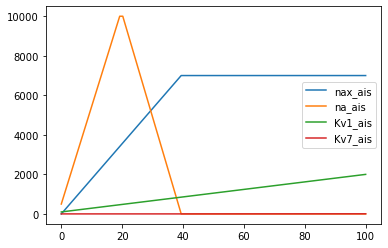

In [3]:
config.plotDistributions()

## Calculate the Ih Sag

The input resistance si calculated by measuring the differences of the maximum voltage in the simutlation window to baseline of a 0 amp stimulus of a stimuli ranging from `i*0.1 in range(0,10)` 

In [4]:
from helpers import ih                   

In [5]:
reload(ih)
baseline, traces = ih.calculateIhSagTraces(cellbuilder)

In [10]:
newtraces = [baseline] + traces

[{'v': array([-65.        , -65.39316432, -65.77785964, ..., -81.81879994,
         -81.81880354, -81.81880715]),
  't': array([0.00000e+00, 2.50000e-02, 5.00000e-02, ..., 7.99950e+02,
         7.99975e+02, 8.00000e+02]),
  'aps': array([], dtype=float64),
  'cellbuilder': <function __main__.<lambda>()>,
  'params': {'dur': 500, 'delay': 100, 'amp': 0}},
 {'v': array([-65.        , -65.39316432, -65.77785964, ..., -81.82986923,
         -81.82987304, -81.82987684]),
  't': array([0.00000e+00, 2.50000e-02, 5.00000e-02, ..., 7.99950e+02,
         7.99975e+02, 8.00000e+02]),
  'aps': array([], dtype=float64),
  'cellbuilder': <function __main__.<lambda>()>,
  'params': {'dur': 500, 'delay': 100, 'amp': -0.025}},
 {'v': array([-65.        , -65.39316432, -65.77785964, ..., -81.84243501,
         -81.84243912, -81.84244322]),
  't': array([0.00000e+00, 2.50000e-02, 5.00000e-02, ..., 7.99950e+02,
         7.99975e+02, 8.00000e+02]),
  'aps': array([], dtype=float64),
  'cellbuilder': <functi

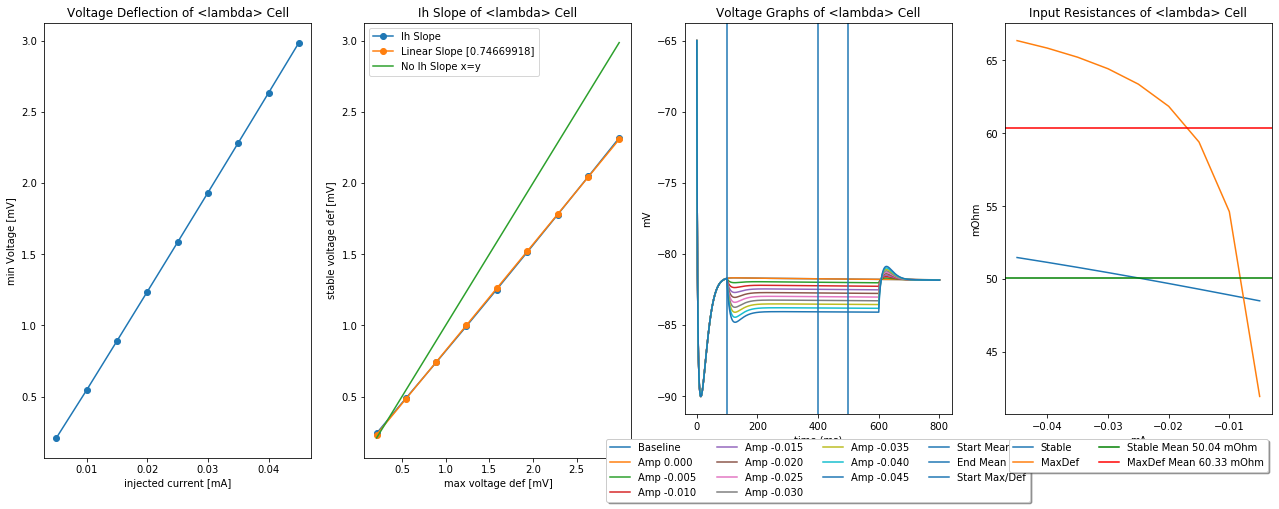

In [15]:
reload(ih)
lala = ih.calculateInputResistanceAndIhSag(cellbuilder)

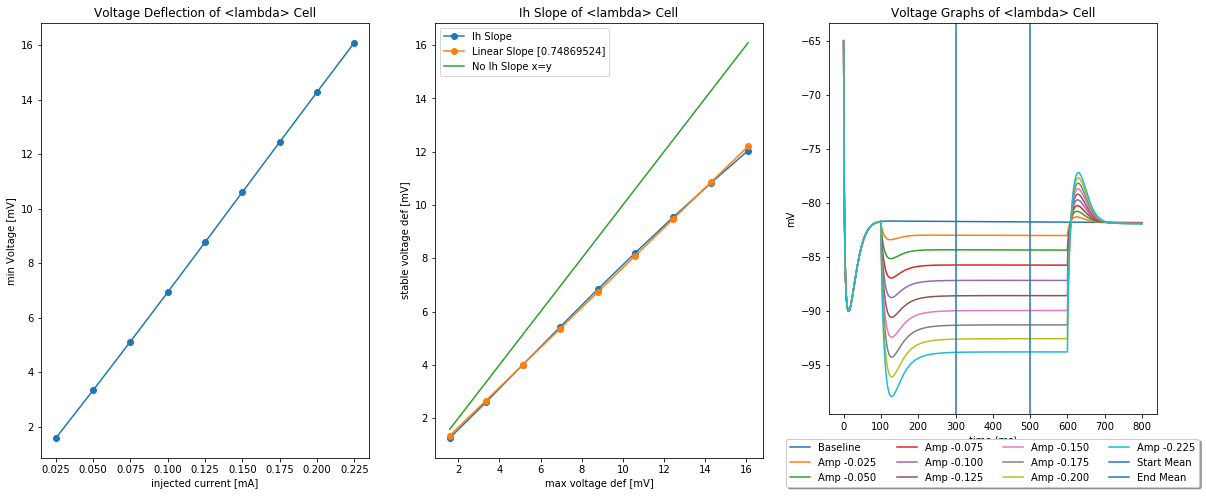

In [18]:
from helpers import generic
reload(generic)

def calculateStableAndMinVoltage(baseline,traces,startoffset=200, endoffset=100, plot=True):
    results = []
    baseline = baseline
    baselineamp = baseline["params"]["amp"]
    baselinedelay = baseline["params"]["delay"]
    baselinedur = baseline["params"]["dur"]
    
    baselinestablebegin = generic.timetoframe(baseline["t"], baselinedelay + startoffset)
    baselinestableend = generic.timetoframe(baseline["t"], baselinedelay + baselinedur - endoffset)
    delayoffset = generic.timetoframe(baseline["t"], baselinedelay)
    
    baselineminvoltage  = baseline["v"][delayoffset:].min()
    baselinestablevoltage = baseline["v"][baselinestablebegin:baselinestableend].mean()
    
    
    for trace in traces:
        amp = trace["params"]["amp"]
        delay = trace["params"]["delay"]
        dur = trace["params"]["dur"]
    
        
        stablebegin = generic.timetoframe(trace["t"], delay + startoffset)
        stableend = generic.timetoframe(trace["t"], delay + dur - endoffset)
        minvoltage = trace["v"][delayoffset:].min() # As we are sending negativ impulses
        
        stablevoltage = trace["v"][stablebegin:stableend].mean()
        
        results.append({"amp": amp,
                        "min": minvoltage,
                        "stable": stablevoltage,
                        "mintobase": minvoltage- baselineminvoltage,
                        "stabletobase": stablevoltage - baselinestablevoltage
                       })
        
    if plot is True:
        
        ystable = [ -el["stabletobase"] for el in results]
        xmin = [ -el["mintobase"] for el in results]

        ymin = [ -el["mintobase"] for el in results]
        xamp = [ -el["amp"] for el in results]
        
        # This will plot a function with slope 1
        minmin = np.array(xmin).max()
        maxmin= np.array(xmin).min()
        x = np.linspace(minmin, maxmin, 100)


        from matplotlib import pyplot
        fig = pyplot.figure(figsize=(20,8)) # Default figsize is (8,6)


        ax2 = pyplot.subplot(131) # Default figsize is (8,6)
        ax2.plot(xamp, ymin, marker="o")
        ax2.set_title("Voltage Deflection of " + cellbuilder.__name__ + " Cell")
        ax2.set_xlabel('injected current [mA]')
        ax2.set_ylabel('min Voltage [mV]')
        
        
        from sklearn.linear_model import LinearRegression
        
        model = LinearRegression()
        lx = np.array(xmin).reshape((-1, 1))
        ly = np.array(ystable)
        model.fit(lx,ly)
        r_sq = model.score(lx, ly)
        y_pred = model.intercept_ + model.coef_ * xmin
        
        ax = pyplot.subplot(132)
        ax.plot(xmin, ystable, marker="o", label="Ih Slope")
        ax.plot(xmin, y_pred, marker="o", label=f"Linear Slope {model.coef_}")
        ax.set_title("Ih Slope of " + cellbuilder.__name__ + " Cell")
        ax.plot(x,x, label="No Ih Slope x=y")
        ax.set_xlabel('max voltage def [mV]')
        ax.set_ylabel('stable voltage def [mV]')
        ax.legend()
        
        ax3 = pyplot.subplot(133)
        ax3.plot(baseline["t"], baseline["v"], label="Baseline".format(baseline["params"]["amp"]))
        for trace in traces:
            ax3.plot(trace["t"], trace["v"], label="Amp {0:.3f}".format(trace["params"]["amp"]))
        ax3.axvline(baselinedelay+startoffset, label="Start Mean", linestyle="-")
        ax3.axvline(baselinedelay+baselinedur-endoffset, label="End Mean" , linestyle="-")
        ax3.set_xlabel('time (ms)')
        ax3.set_ylabel('mV')
        box3 = ax3.get_position()
        ax3.set_position([box3.x0, box3.y0 + box3.height * 0.1, box3.width, box3.height * 0.9])
        ax3.set_title("Voltage Graphs of " + cellbuilder.__name__ + " Cell")
        ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=4)
        pyplot.show()  
    
    
    
    return results
        

results= calculateStableAndMinVoltage(baseline,traces)